# Different types of metrics with pytorch implementations, metrics chosen from [1](https://arxiv.org/pdf/1806.07755.pdf)

In [2]:
import torch
import torchvision

# Create dataloader from data_dir folder of images
def create_dataloader(data_dir, batch_size):
    dataset = torchvision.datasets.ImageFolder(
        root=data_dir,
        transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
        ])
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=1,
    )
    return dataloader

In [3]:
bsize = 624 # Need all batches to be same size, so use smallest batch size

In [4]:
fmnist = create_dataloader("../data/metric-comparison/fmnist", bsize)
xray_real_train = create_dataloader("../data/metric-comparison/xray/real-train-no-aug", bsize)
xray_real_test = create_dataloader("../data/metric-comparison/xray/real-test", bsize)
xray_diffusion = create_dataloader("../data/metric-comparison/xray/diffusion/epochs300-no-aug", bsize)

In [5]:
import itertools
ds = {
    "fmnist": fmnist,
    "xray_real_train": xray_real_train,
    "xray_real_test": xray_real_test,
    "xray_diffusion": xray_diffusion
}
# Create pairs with name of each dataset as key
pairs = {
    f"{k1} vs {k2}": (v1, v2)
    for (k1, v1), (k2, v2) in itertools.combinations(ds.items(), 2)
}

Basically all of these can operate in the feature space of a pre-trained model on the ImageNet dataset. Map input into any semantically meaningful feature space; imagenet models tend to have a good feature representation, so using them is safe.

### Inception Score, most widely adopted in literature [source](https://papers.nips.cc/paper/6125-improved-techniques-for-training-gans.pdf)

Pytorch implementation: https://github.com/sbarratt/inception-score-pytorch

Note, [this paper](https://arxiv.org/pdf/1801.01973.pdf) warns against using the inception score.

Inception score simply evaluates the distribution of the (generated) images.
From [Wikipedia](https://en.wikipedia.org/wiki/Inception_score):
The Inception Score is maximized when the following conditions are true:
1. The entropy of the distribution of labels predicted by the Inceptionv3 model for the generated images is minimized. In other words, the classification model confidently predicts a single label for each image. Intuitively, this corresponds to the desideratum of generated images being "sharp" or "distinct".
2. The predictions of the classification model are evenly distributed across all possible labels. This corresponds to the desideratum that the output of the generative model is "diverse".

### Fréchet Inception Distance (FID), [source](https://arxiv.org/abs/1706.08500)

PyTorch implementation: https://github.com/mseitzer/pytorch-fid

FID compares the distribution of generated images with the distribution of a set of real images ("ground truth").

From [Wikipedia](https://en.wikipedia.org/wiki/Fr%C3%A9chet_inception_distance), FID is the current standard metric for assessing the quality of generative models as of 2020

Based on Frechet distance (aka Wassersein-2 distance), and calculated as:

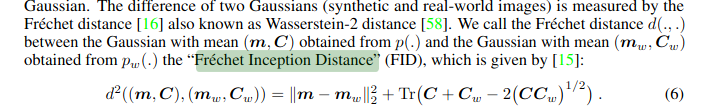

According to [W&B](https://wandb.ai/ayush-thakur/gan-evaluation/reports/How-to-Evaluate-GANs-using-Frechet-Inception-Distance-FID---Vmlldzo0MTAxOTI), minimum suggested sample size is 10k which is computationally expensive, I used 100

Need to modify to have data folders where all images have same size.

#### Real train

In [7]:
!python -m pytorch_fid --num-workers 1 --device cuda:0 ../data/metric-comparison/xray/real-train-no-aug ../data/metric-comparison/xray/real-test

100%|███████████████████████████████████████████| 14/14 [00:06<00:00,  2.23it/s]
FID:  31.248856525632732


In [9]:
real_train_vs_real_test = 31.25

In [8]:
!python -m pytorch_fid --num-workers 1 --device cuda:0 ../data/metric-comparison/xray/real-train-no-aug ../data/metric-comparison/xray/real-train

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.03it/s]
FID:  130.1048798904933


In [10]:
real_train_vs_real_train_no_aug = 130.105

#### Old models

In [3]:
!python -m pytorch_fid --num-workers 1 --device cuda:0 ../data/metric-comparison/xray/real-train ../data/metric-comparison/xray/diffusion/epochs50

100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.97it/s]
FID:  226.69796695956566


In [11]:
real_train_vs_50epochs = 226.6979

In [4]:
!python -m pytorch_fid --num-workers 1 --device cuda:0 ../data/metric-comparison/xray/real-test ../data/metric-comparison/xray/diffusion/epochs50

100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.99it/s]
FID:  200.99994307324533


In [12]:
real_test_vs_50epochs = 200.9999

In [ ]:
!python -m pytorch_fid --num-workers 1 --device cuda:0 ../data/metric-comparison/xray/diffusion/epochs50 ../data/metric-comparison/fmnist/real

100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.95it/s]
FID:  312.2984825813693


In [ ]:
fmnist_vs_epochs50 = 312.2985

In [ ]:
!python -m pytorch_fid --num-workers 1 --device cuda:0 ../data/metric-comparison/xray/diffusion/epochs300 ../data/metric-comparison/xray/real-train

100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.96it/s]
FID:  214.18776141131417


In [ ]:
real_train_vs_300epochs = 214.1878

In [ ]:
!python -m pytorch_fid --num-workers 1 --device cuda:0 ../data/metric-comparison/xray/diffusion/epochs300 ../data/metric-comparison/xray/real-test

100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.96it/s]
FID:  195.95871663472013


In [ ]:
real_test_vs_300epochs = 195.9587

In [ ]:
!python -m pytorch_fid --num-workers 1 --device cuda:0 ../data/metric-comparison/xray/diffusion/epochs300 ../data/metric-comparison/fmnist/real

100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.91it/s]
FID:  293.492523508075


In [ ]:
fmnist_vs_300epochs = 293.4925

In [ ]:
!python -m pytorch_fid --num-workers 1 --device cuda:0 ../data/metric-comparison/xray/diffusion/epochs300 ../data/metric-comparison/xray/diffusion/epochs50

100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.99it/s]
FID:  131.99729479875032


In [ ]:
epochs50_vs_300epochs = 131.9973

#### FMNIST

In [11]:
!python -m pytorch_fid --num-workers 1 --device cuda:0 ../data/metric-comparison/xray/real-train-no-aug ../data/metric-comparison/fmnist/real

100%|███████████████████████████████████████████| 22/22 [00:09<00:00,  2.21it/s]
FID:  176.8930151608833


In [5]:
fmnist_vs_real_train = 176.893

In [12]:
!python -m pytorch_fid --num-workers 1 --device cuda:0 ../data/metric-comparison/xray/real-test ../data/metric-comparison/fmnist/real

100%|███████████████████████████████████████████| 22/22 [00:10<00:00,  2.17it/s]
FID:  175.25483357712193


In [13]:
fmnist_vs_real_test = 175.255

### Diffusion vs rest

In [14]:
!python -m pytorch_fid --num-workers 1 --device cuda:0 ../data/metric-comparison/xray/real-train-no-aug ../data/metric-comparison/xray/diffusion/epochs300-no-augmentation

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.00it/s]
FID:  193.9223919389553


In [15]:
real_train_vs_300epochs_no_aug = 193.922

In [16]:
!python -m pytorch_fid --num-workers 1 --device cuda:0 ../data/metric-comparison/xray/real-test ../data/metric-comparison/xray/diffusion/epochs300-no-augmentation

100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.98it/s]
FID:  207.90053679688504


In [17]:
real_test_vs_300epochs_no_aug = 207.901

In [18]:
!python -m pytorch_fid --num-workers 1 --device cuda:0 ../data/metric-comparison/fmnist/real ../data/metric-comparison/xray/diffusion/epochs300-no-augmentation

100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.98it/s]
FID:  335.0075016162401


In [19]:
fmnist_vs_300epochs_no_aug = 335.008

In [19]:
all_metrics = {
    'real_train_vs_real_test': real_train_vs_real_test,
    # 'real_train_vs_real_train': real_train_vs_real_train,
    'real_train_vs_50epochs': real_train_vs_50epochs,
    'real_test_vs_50epochs': real_test_vs_50epochs,
    'fmnist_vs_real_train': fmnist_vs_real_train,
    'fmnist_vs_real_test': fmnist_vs_real_test,
    'fmnist_vs_epochs50': fmnist_vs_epochs50,
    'real_train_vs_300epochs': real_train_vs_300epochs,
    'real_test_vs_300epochs': real_test_vs_300epochs,
    'fmnist_vs_300epochs': fmnist_vs_300epochs
}

In [21]:
for metric in all_metrics.items():
    print(metric[0])
    print("\t", metric[1])

real_train_vs_real_test
	 145.825
real_train_vs_real_train
	 0.0
real_train_vs_50epochs
	 226.6979
real_test_vs_50epochs
	 200.9999
fmnist_vs_real_train
	 223.3382
fmnist_vs_real_test
	 234.1815
fmnist_vs_epochs50
	 312.2985
real_train_vs_300epochs
	 214.1878
real_test_vs_300epochs
	 195.9587
fmnist_vs_300epochs
	 293.4925


### TODO: Compare individual classes as well to see how similar by class different data is

### Kernel Inception Distance (KID), [source](https://arxiv.org/pdf/1801.01401.pdf)

KID is the squared MMD between Inception representations.

https://torchmetrics.readthedocs.io/en/stable/image/kernel_inception_distance.html

In [7]:
import torchmetrics.image.kid as tik
import importlib
importlib.reload(tik)

/home/nashir/miniconda3/envs/cap5516-final/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /home/nashir/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:04<00:00, 21.8MB/s]


In [1]:
for pair, (d1, d2) in pairs.items():
    kid = tik.KernelInceptionDistance(subset_size=50)
    print(f"pair: {pair}")
    X, _ = next(iter(d1))
    Y, _ = next(iter(d2))

    # Convert to torch tensor with dtype uint8 and scale to [0, 255]
    X = X * 255
    Y = Y * 255
    X = X.type(torch.uint8)
    Y = Y.type(torch.uint8)

    kid.update(X, real=True)
    kid.update(Y, real=False)
    kid_mean, kid_std = kid.compute()

    print(f"kid: {kid_mean:.4f}, {kid_std:.4f}")
    print()


NameError: name 'pairs' is not defined

### Wasserstein distance

### Mode score, [source](https://arxiv.org/abs/1612.02136)

PyTorch implementation: https://github.com/xuqiantong/GAN-Metrics/blob/45dc74fac8b2452d5f37f035bba7352f873c7f91/metric.py#L356-L361

### Difference in maximum mean discrepancies (MMDs), [source](https://arxiv.org/abs/1511.04581)

PyTorch Implementation: https://github.com/ZongxianLee/MMD_Loss.Pytorch

Implementation 2: https://www.onurtunali.com/ml/2019/03/08/maximum-mean-discrepancy-in-machine-learning.html

### Classifier two-sample test, also called 1-NN classifier [source](https://arxiv.org/abs/1610.06545)

TODO: add this later if time

Note: human evaluation tends to be biased towards the visual quality of generated samples and neglect the overall distributional characteristics, which are important for unsupervised learning, [source](https://arxiv.org/pdf/1806.07755.pdf).

### SSIM and MS-SSIM

In [7]:
from pytorch_msssim import ssim

In [11]:
for pair, (d1, d2) in pairs.items():
    print(f"pair: {pair}")
    X, _ = next(iter(d1))
    Y, _ = next(iter(d2))

    print(f"Range of X: {X.min()}, {X.max()}, Range of Y: {Y.min()}, {Y.max()}")

    # # Convert to torch tensor with dtype uint8 and scale to [0, 255]
    # X = X * 255
    # Y = Y * 255
    # X = X.type(torch.uint8)
    # Y = Y.type(torch.uint8)

    # Note: resolution of images was too small for MS-SSIM to work
    ssim_val = ssim(X, Y, data_range=1, size_average=True)
    print(f"ssim: {ssim_val:.4f}")
    print()


pair: fmnist vs xray_real_train
Range of X: 0.0, 1.0, Range of Y: 0.0, 1.0
ssim: 0.0623

pair: fmnist vs xray_real_test
Range of X: 0.0, 1.0, Range of Y: 0.0, 1.0
ssim: 0.0757

pair: fmnist vs xray_diffusion
Range of X: 0.0, 1.0, Range of Y: 0.0, 1.0
ssim: 0.0424

pair: xray_real_train vs xray_real_test
Range of X: 0.0, 1.0, Range of Y: 0.0, 1.0
ssim: 0.2996

pair: xray_real_train vs xray_diffusion
Range of X: 0.0, 1.0, Range of Y: 0.0, 1.0
ssim: 0.2713

pair: xray_real_test vs xray_diffusion
Range of X: 0.0, 1.0, Range of Y: 0.0, 1.0
ssim: 0.2833



### 